## CIS 580, Machine Perception, Spring 2023
### Homework 5
#### Due: Thursday April 27th 2023, 11:59pm ET

Instructions: Create a folder in your Google Drive and place inside this .ipynb file. Open the jupyter notebook with Google Colab. Refrain from using a GPU during implementing and testing the whole thing. You should switch to a GPU runtime only when performing the final training (of the 2D image or the NeRF) to avoid GPU usage runouts. 

### Part 1: Fitting a 2D Image

In [30]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
import gdown
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

In [8]:
A=torch.randint(1,104,[1])
print(A)

tensor([18])


We first download the image from the web. We normalize the image so the pixels are in between the range of [0,1].

In [9]:
url = "https://drive.google.com/file/d/1-Cugk9WiFX2CPjWG5taX3868Gdd0PEVT/view?usp=share_link"
gdown.download(url=url, output='starry_night.jpg', quiet=False, fuzzy=True)

# Load painting image
painting = imageio.imread("starry_night.jpg")
painting = torch.from_numpy(np.array(painting, dtype=np.float32)/255.).to(device)
height_painting, width_painting = painting.shape[:2]

Downloading...
From: https://drive.google.com/uc?id=1-Cugk9WiFX2CPjWG5taX3868Gdd0PEVT
To: d:\Me\priyanshun\Masters\Pennsylvania\Courses\CIS 580\NERF\starry_night.jpg
100%|██████████| 5.65k/5.65k [00:00<00:00, 5.66MB/s]


1.1 Complete the function positional_encoding()

In [10]:
def positional_encoding(x, num_frequencies=6, incl_input=True):
    torch.pi = torch.acos(torch.zeros(1)).item() * 2
    
    """
    Apply positional encoding to the input.
    
    Args:
    x (torch.Tensor): Input tensor to be positionally encoded. 
      The dimension of x is [N, D], where N is the number of input coordinates,
      and D is the dimension of the input coordinate.
    num_frequencies (optional, int): The number of frequencies used in
     the positional encoding (default: 6).
    incl_input (optional, bool): If True, concatenate the input with the 
        computed positional encoding (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor. 
    """
    
    results = []
    if incl_input:
        results.append(x)
    ############################  TODO 1(a) BEGIN  ############################
    # encode input tensor and append the encoded tensor to the list of results.
    L=num_frequencies
    for i in range (L):
        theta=2**i*torch.pi*x
        a=torch.sin(theta)
        b=torch.cos(theta)
        results.append(a)
        results.append(b)

    # results = []
    # if incl_input:
    #     results.append(x)
    # L = num_frequencies
    # thetas = 2 ** torch.arange(L) * torch.pi * x
    # a = torch.sin(thetas)
    # b = torch.cos(thetas)
    # d23 = torch.stack((a,b)).T
    
    # r = torch.cat(d23, dim=-1)
    # results.append(r)
    
    #############################  TODO 1(a) END  ##############################
    return torch.cat(results, dim=-1)

1.2 Complete the class model_2d() that will be used to fit the 2D image.


In [11]:
class model_2d(nn.Module):
    
    """
    Define a 2D model comprising of three fully connected layers,
    two relu activations and one sigmoid activation.
    """
    
    def __init__(self, filter_size=128, num_frequencies=6):
        super().__init__()
        #############################  TODO 1(b) BEGIN  ############################
        input_dim=2*num_frequencies*2+2
        middle_dim=filter_size
        output_dim=3
        self.input_fc=nn.Linear(input_dim, middle_dim)
        self.hidden_fc=nn.Linear(middle_dim,middle_dim)
        self.output_fc=nn.Linear(middle_dim, output_dim)
        #############################  TODO 1(b) END  ##############################        

    def forward(self, x):
        #############################  TODO 1(b) BEGIN  ############################
        batch_size=x.shape[0]
        x=x.view(batch_size,-1)

        x=F.relu(self.input_fc(x))
        x=F.relu(self.hidden_fc(x))
        x=F.sigmoid(self.output_fc(x))

        #############################  TODO 1(b) END  ##############################  
        return x

You need to complete 1.1 and 1.2 first before completing the train_2d_model function. Don't forget to transfer the completed functions from 1.1 and 1.2 to the part1.py file and upload it to the autograder. 

Fill the gaps in the train_2d_model() function to train the model to fit the 2D image. 

In [12]:
def train_2d_model(test_img, num_frequencies, device, model=model_2d, positional_encoding=positional_encoding, show=True):

    # Optimizer parameters
    lr = 5e-4
    iterations = 10000
    height, width = test_img.shape[:2]

    # Number of iters after which stats are displayed
    display = 2000  
    
    # Define the model and initialize its weights.
    model2d = model(num_frequencies=num_frequencies)
    model2d.to(device)

    def weights_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    model2d.apply(weights_init)

    #############################  TODO 1(c) BEGIN  ############################
    # Define the optimizer #do we have to do adam optimizer
    optimizer=torch.optim.Adam(model2d.parameters(), lr=lr)

    #############################  TODO 1(c) END  ############################

    # Seed RNG, for repeatability
    seed = 5670
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Lists to log metrics etc.
    psnrs = []
    iternums = []

    t = time.time()
    t0 = time.time()

    #############################  TODO 1(c) BEGIN  ############################
    # Create the 2D normalized coordinates, and apply positional encoding to them
    w=width_painting
    h=height_painting
    
    W=torch.linspace(0,1,w)
    H=torch.linspace(0,1,h)

    no_of_cells=w*h
    x=torch.zeros((no_of_cells,2))

    for i in range(h):
        for j in range(w):
            pos_of_cell= (i*w)+j
            x[pos_of_cell]=torch.tensor([W[j], H[i]]) ##doubt
    
    encoded_2d=positional_encoding(x, num_frequencies=num_frequencies)
    # print(encoded_2d.shape)
    encoded_2d=encoded_2d.to(device)
    
    #############################  TODO 1(c) END  ############################

    for i in range(iterations+1):
        optimizer.zero_grad()
        #############################  TODO 1(c) BEGIN  ############################
        # Run one iteration
        # Compute mean-squared error between the predicted and target images. Backprop!
        fw=model2d.forward(x=encoded_2d)
        model_3D=fw.reshape((h,w,3))
        loss = F.mse_loss(model_3D, test_img)
        loss.backward()
        optimizer.step() # Confirm do we have to do this for multiple iterations or not

        pred=model_3D

        #############################  TODO 1(c) END  ############################

        # Display images/plots/stats
        if i % display == 0 and show:
            #############################  TODO 1(c) BEGIN  ############################
            # Calculate psnr
            R=pred.max()
            R_MSE=(R**2)/loss
            psnr=10 * torch.log10(R_MSE)
            #############################  TODO 1(c) END  ############################

            print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f" % psnr.item(), \
                "Time: %.2f secs per iter" % ((time.time() - t) / display), "%.2f secs in total" % (time.time() - t0))
            t = time.time()

            psnrs.append(psnr.item())
            iternums.append(i)

            plt.figure(figsize=(13, 4))
            plt.subplot(131)
            plt.imshow(pred.detach().cpu().numpy())
            plt.title(f"Iteration {i}")
            plt.subplot(132)
            plt.imshow(test_img.cpu().numpy())
            plt.title("Target image")
            plt.subplot(133)
            plt.plot(iternums, psnrs)
            plt.title("PSNR")
            plt.show()

    print('Done!')
    return pred.detach().cpu()

Train the model to fit the given image without applying positional encoding to the input, and by applying positional encoding of two different frequencies to the input; L = 2 and L = 6.

Iteration 0  Loss: 0.0567  PSNR: 8.27 Time: 0.00 secs per iter 1.73 secs in total


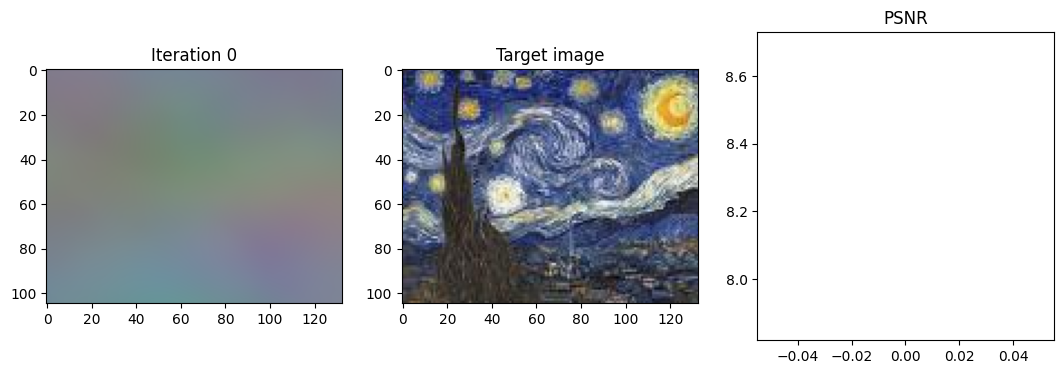

Iteration 2000  Loss: 0.0088  PSNR: 19.91 Time: 0.00 secs per iter 9.88 secs in total


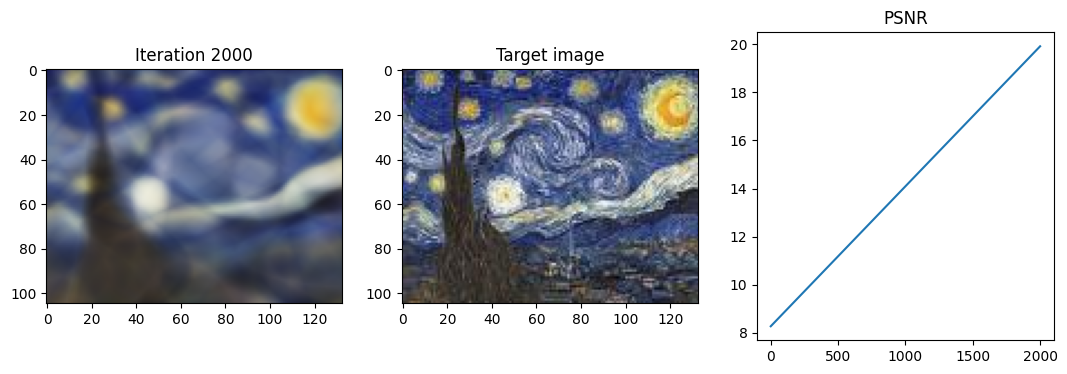

Iteration 4000  Loss: 0.0078  PSNR: 20.60 Time: 0.00 secs per iter 18.25 secs in total


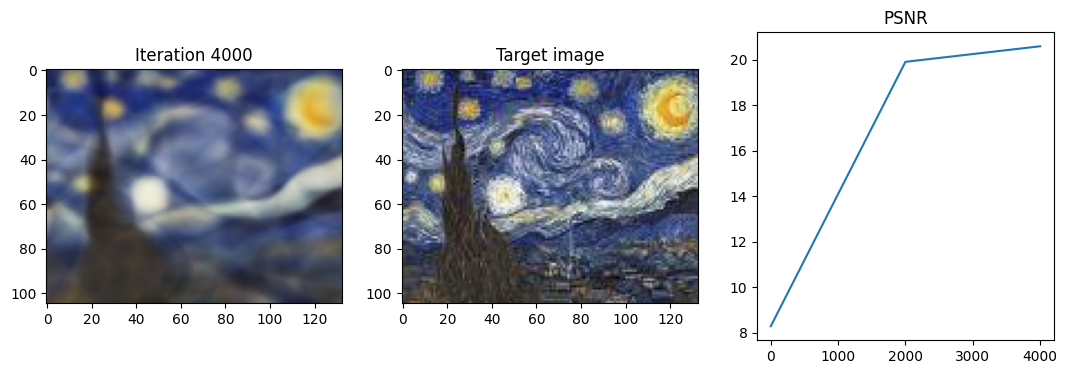

Iteration 6000  Loss: 0.0073  PSNR: 20.84 Time: 0.00 secs per iter 26.63 secs in total


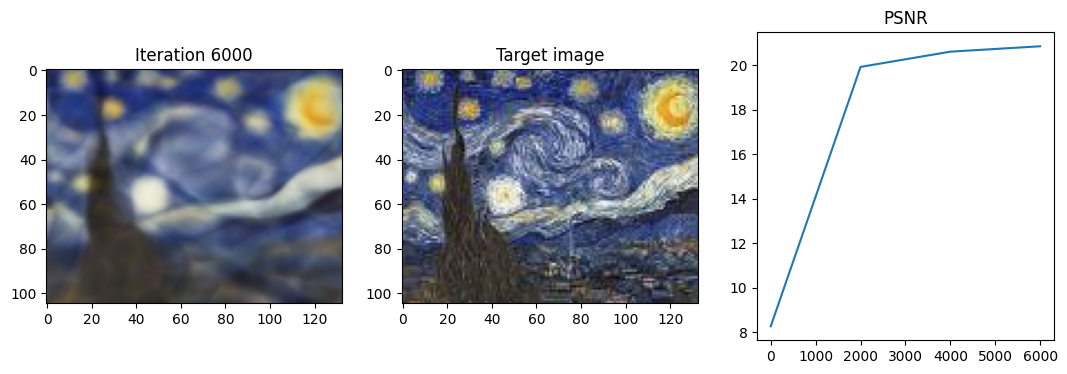

Iteration 8000  Loss: 0.0069  PSNR: 20.98 Time: 0.00 secs per iter 34.98 secs in total


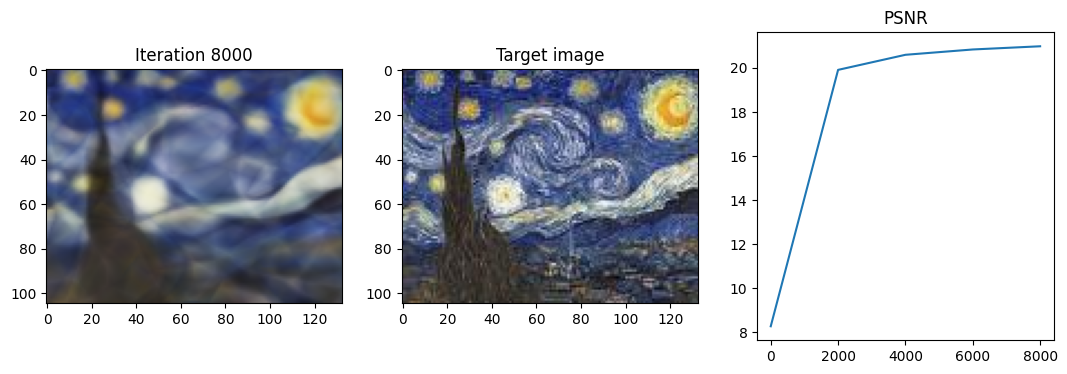

Iteration 10000  Loss: 0.0067  PSNR: 21.08 Time: 0.00 secs per iter 43.52 secs in total


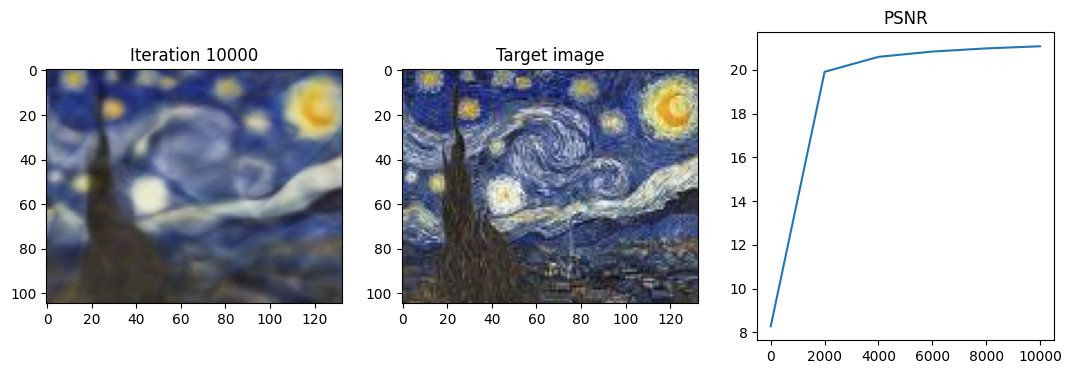

Done!


In [13]:
_ = train_2d_model(test_img=painting, num_frequencies=2, device=device)

### Part 2: Fitting a 3D Image

In [31]:
import os
import gdown
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
url = "https://drive.google.com/file/d/15W2EK8LooxTMfD0v5vo2BnBMse5ZzlVj/view?usp=share_link"
gdown.download(url=url, output='lego_data.npz', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=15W2EK8LooxTMfD0v5vo2BnBMse5ZzlVj
To: d:\Me\priyanshun\Masters\Pennsylvania\Courses\CIS 580\NERF\lego_data.npz
100%|██████████| 12.7M/12.7M [00:00<00:00, 17.6MB/s]


'lego_data.npz'

Here, we load the data that is comprised by the images, the R and T matrices of each camera position with respect to the world coordinates and the intrinsics parameters K of the camera.

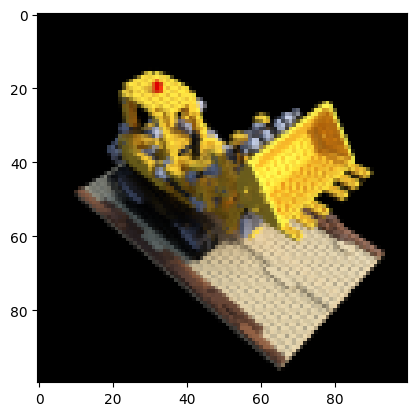

In [33]:
# Load input images, poses, and intrinsics
data = np.load("lego_data.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
poses = data["poses"]
poses = torch.from_numpy(poses).to(device)

# Camera intrinsics
intrinsics = data["intrinsics"]
intrinsics = torch.from_numpy(intrinsics).to(device)

# Hold one image out (for test).
test_image, test_pose = images[101], poses[101]
test_image = torch.from_numpy(test_image).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(test_image.detach().cpu().numpy())
plt.show()

2.1 Complete the following function that calculates the rays that pass through all the pixels of an HxW image

In [34]:
def get_rays(height, width, intrinsics, Rcw, Tcw): # Rwc, Twc
    
    """
    Compute the origin and direction of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height: the height of an image.
    width: the width of an image.
    intrinsics: camera intrinsics matrix of shape (3, 3).
    Rcw: Rotation matrix of shape (3,3) from camera to world coordinates.
    Tcw: Translation vector of shape (3,1) that transforms

    Returns:
    ray_origins (torch.Tensor): A tensor of shape (height, width, 3) denoting the centers of
      each ray. Note that desipte that all ray share the same origin, here we ask you to return 
      the ray origin for each ray as (height, width, 3).
    ray_directions (torch.Tensor): A tensor of shape (height, width, 3) denoting the
      direction of each ray.
    """



    device = intrinsics.device
    ray_directions = torch.zeros((height, width, 3), device=device)  # placeholder
    ray_origins = torch.zeros((height, width, 3), device=device)  # placeholder
    
    #############################  TODO 2.1 BEGIN  ##########################  

    w_arr=torch.arange(width, device=device)
    h_arr=torch.arange(height, device=device)
    grid_y, grid_x=torch.meshgrid(h_arr,w_arr)

    x=grid_x.float()
    y=grid_y.float()
    I=torch.ones_like(x)

    size=height*width

    pico=torch.stack([x,y,I],dim=-1)
    # pixel=pico.reshape(3,size)
    # pixel=pico.reshape(size,3).T
    pixel=pico.reshape(height*width,3).T

    K_inv=torch.linalg.inv(intrinsics)
    camera=torch.matmul(K_inv, pixel)

    ray_directions=torch.matmul(Rcw, camera)
    ray_directions=ray_directions.T
    ray_directions=ray_directions.reshape(height, width, 3)

    ray_origins=torch.reshape(Tcw, (1,1,3))
    # ray_origins=ray_origins.reshape(height, width ,3)
    ray_origins=ray_origins.expand(height, width ,3)


    #############################  TODO 2.1 END  ############################
    return ray_origins, ray_directions

Complete the next function to visualize how is the dataset created. You will be able to see from which point of view each image has been captured for the 3D object. What we want to achieve here, is to being able to interpolate between these given views and synthesize new realistic views of the 3D object.

In [35]:
# def plot_all_poses(poses):
    
#     #############################  TODO 2.1 BEGIN  ############################
#     # print (poses)

#     #############################  TODO 2.1 END  ############################

#     ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
#     _ = ax.quiver(origins[..., 0].flatten(),
#                   origins[..., 1].flatten(),
#                   origins[..., 2].flatten(),
#                   directions[..., 0].flatten(),
#                   directions[..., 1].flatten(),
#                   directions[..., 2].flatten(), length=0.12, normalize=True)
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('z')
#     plt.show()
    
# plot_all_poses(data['poses'])

2.2 Complete the following function to implement the sampling of points along a given ray.

In [36]:
def stratified_sampling(ray_origins, ray_directions, near, far, samples):

    """
    Sample 3D points on the given rays. The near and far variables indicate the bounds of sampling range.

    Args:
    ray_origins: Origin of each ray in the "bundle" as returned by the
      get_rays() function. Shape: (height, width, 3).
    ray_directions: Direction of each ray in the "bundle" as returned by the
      get_rays() function. Shape: (height, width, 3).
    near: The 'near' extent of the bounding volume.
    far:  The 'far' extent of the bounding volume.
    samples: Number of samples to be drawn along each ray.
  
    Returns:
    ray_points: Query 3D points along each ray. Shape: (height, width, samples, 3).
    depth_points: Sampled depth values along each ray. Shape: (height, width, samples).
    """

    #############################  TODO 2.2 BEGIN  ############################
    h,w,d=ray_directions.shape
    initial=torch.arange(samples, device=ray_origins.device)
    t_near=near
    t_far=far
    
    division=torch.rand(h,w,samples, device=ray_origins.device)
    total=initial+division
    e=1e-6
    sum=samples+e
    points=(total/sum).expand(h,w, samples)

    depth_points=t_near +(t_far-t_near)*points

    o=ray_origins[..., None,:]
    td=depth_points[..., None]*ray_directions[..., None, :]
    ray_points=o+td

    #############################  TODO 2.2 END  ############################
    return ray_points, depth_points

2.3 Define the network architecture of NeRF along with a function that divided data into chunks to avoid memory leaks during training.

In [37]:
class nerf_model(nn.Module):
    
    """
    Define a NeRF model comprising eight fully connected layers and following the
    architecture described in the NeRF paper. 
    """

    def __init__(self, filter_size=256, num_x_frequencies=6, num_d_frequencies=3):
        super().__init__()

        #############################  TODO 2.3 BEGIN  ############################
        x_input=3*num_x_frequencies*2+3
        d_input=3*num_d_frequencies*2+3
        f=filter_size
        f2=filter_size//2
        f2=128

        self.inp=nn.Linear(x_input, f)
        self.h1=nn.Linear(f,f)
        self.h2=nn.Linear(f,f)
        self.h3=nn.Linear(f,f)
        self.h4=nn.Linear(f,f)
        self.h5=nn.Linear(f+x_input, f)
        self.h6=nn.Linear(f,f)
        self.h7=nn.Linear(f,f)
        self.sig=nn.Linear(f,1)
        self.h8=nn.Linear(f,f)
        self.h9=nn.Linear(f+d_input,f2)
        self.out=nn.Linear(f2, 3)



        #############################  TODO 2.3 END  ############################


    def forward(self, x, d):
        #############################  TODO 2.3 BEGIN  ############################
        size_x=x.shape[0]
        size_d=d.shape[0]
        batch_size=x.shape[0]
        x=x.view(batch_size,-1)

        # xn=x
        xf=F.relu(self.inp(x))
        xf=F.relu(self.h1(xf))
        xf=F.relu(self.h2(xf))
        xf=F.relu(self.h3(xf))
        xf=F.relu(self.h4(xf))

        cat1=torch.cat([xf, x], dim=-1)

        xf=F.relu(self.h5(cat1))
        xf=F.relu(self.h6(xf))
        xfn=F.relu(self.h7(xf))

        sigma=self.sig(xfn)
        extra=self.h8(xfn)
        
        cat2=torch.cat([extra, d], dim=-1)

        xf=F.relu(self.h9(cat2))
        rgb=torch.sigmoid(self.out(xf))

        #############################  TODO 2.3 END  ############################
        return rgb, sigma

In [38]:
def get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies):
    
    def get_chunks(inputs, chunksize = 2**15):
        return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]
    
    """
    This function returns chunks of the ray points and directions to avoid memory errors with the
    neural network. It also applies positional encoding to the input points and directions before 
    dividing them into chunks, as well as normalizing and populating the directions.
    """
    #############################  TODO 2.3 BEGIN  ############################
    s1=ray_points.shape[2]
    ray_directions_norm=torch.norm(ray_directions, dim=-1, keepdim=True)
    rdn=ray_directions/ray_directions_norm
    
    rd_flat=rdn.reshape(-1,3).unsqueeze(1)
    
    r_repeat=rd_flat.repeat(1,s1,1)
    rp_flat=ray_points.reshape(-1,s1,3)

    rp_flat=rp_flat.reshape(-1,3)
    r_repeat=r_repeat.reshape(-1,3)
    # r_block=torch.cat([rp_flat, r_repeat], dim=-1).reshape(-1,6)
    
    
    # rppe=positional_encoding(r_block[:,:3], num_x_frequencies)
    # rdpe=positional_encoding(r_block[:, 3:], num_d_frequencies)

    rppe=positional_encoding(rp_flat, num_x_frequencies)
    rdpe=positional_encoding(r_repeat, num_d_frequencies)
    
    
    ray_directions_batches=get_chunks(rdpe)
    ray_points_batches=get_chunks(rppe)
    #############################  TODO 2.3 END  ############################

    return ray_points_batches, ray_directions_batches

2.4 Compute the compositing weights of samples on camera ray and then complete the volumetric rendering procedure to reconstruct a whole RGB image from the sampled points and the outputs of the neural network. 

In [39]:
def volumetric_rendering(rgb, s, depth_points):

    """
    Differentiably renders a radiance field, given the origin of each ray in the
    "bundle", and the sampled depth values along them.

    Args:
    rgb: RGB color at each query location (X, Y, Z). Shape: (height, width, samples, 3).
    sigma: Volume density at each query location (X, Y, Z). Shape: (height, width, samples).
    depth_points: Sampled depth values along each ray. Shape: (height, width, samples).
  
    Returns:
    rec_image: The reconstructed image after applying the volumetric rendering to every pixel.
    Shape: (height, width, 3)
    """
    
    #############################  TODO 2.4 BEGIN  ############################
    device=rgb.device
    
    d1=depth_points[..., 1:]
    d2=depth_points[...,:1]
    d3=depth_points[..., :-1]
    shape=d2.shape
    # d13=torch.diff(d1,d3)
    
    # # deln=torch.tensor([Inf])
    # # deln=torch.tensor([1e9]).expand()
    del1=torch.ones_like(depth_points).to(device)*1e9
    # del1=d_one*Inf
    del1[..., :-1]=torch.diff(depth_points, dim=-1)

    r_sigma=F.relu(s)
    d_new=del1.reshape_as(s)
    sgd=-r_sigma*d_new
    temp=torch.exp(sgd)
    Ti=torch.cumprod(temp, dim=-1)
    T_i=torch.roll(Ti, shifts=1, dims=-1)
    SigmaDel_i=-F.relu(s)*del1.reshape_as(s)

    A=T_i*(1-temp)
    B=A[...,None]*rgb
    rec_image=B.sum(dim=-2)


    #############################  TODO 2.4 END  ############################

    return rec_image

2.5 Combine everything together. Given the pose position of a camera, compute the camera rays and sample the 3D points along these rays. Divide those points into batches and feed them to the neural network. Concatenate them and use them for the volumetric rendering to reconstructed the final image.

In [40]:
def one_forward_pass(height, width, intrinsics, pose, near, far, samples, model, num_x_frequencies, num_d_frequencies):
    
    #############################  TODO 2.5 BEGIN  ############################

    #compute all the rays from the image


    #sample the points from the rays


    #divide data into batches to avoid memory errors


    #forward pass the batches and concatenate the outputs at the end

    R_cw=pose[:3, :3].to(device)
    T_cw=pose[:3, -1].to(device)

    ro,rd=get_rays(height, width, intrinsics, R_cw, T_cw)
    ro=ro.to(device)
    rd=rd.to(device)
    rp, dp=stratified_sampling(ro,rd,near, far, samples)
    rpb, rdb=get_batches(rp,rd, num_x_frequencies, num_d_frequencies)

    all_rgb=[]
    all_sigma=[]

    for i in range(len(rpb)):
        rp1=rpb[i].float()
        rd1=rdb[i].float()
        rgbi, sigmai=model(rp1, rd1)
        all_rgb.append(rgbi)
        all_sigma.append(sigmai)
    
    rgb=torch.concat(all_rgb).reshape((height, width, samples,3))
    sigma=torch.concat(all_sigma).reshape((height, width, samples))


    # Apply volumetric rendering to obtain the reconstructed image
    rec_image=volumetric_rendering(rgb, sigma, dp)
    
    #############################  TODO 2.5 END  ############################

    return rec_image

If you manage to pass the autograder for all the previous functions, then it is time to train a NeRF! We provide the hyperparameters for you, we initialize the NeRF model and its weights, and we define a couple lists that will be needed to store results. 

In [41]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
iterations = 3000
samples = 64
display = 25
near = 0.667
far = 2

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnrs = []
iternums = []

t = time.time()
t0 = time.time()

In [42]:
for i in range(iterations+1):

    #############################  TODO 2.6 BEGIN  ############################
    #choose randomly a picture for the forward pass
    # torch.cuda.empty_cache()
    idx=torch.randint(low=0,high=100,size=(1,))
    pose=poses[idx].squeeze(0).float()
    img=images[idx].squeeze(0).float()
    height, width=img.shape[:2]
    test_recw=one_forward_pass(height, width, intrinsics, pose, near, far, samples, model, num_x_frequencies, num_d_frequencies)
    loss = F.mse_loss(test_recw, img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #############################  TODO 2.6 END  ############################

    # Display images/plots/stats
    if i % display == 0:
        with torch.no_grad():
        #############################  TODO 2.6 BEGIN  ############################
            # Render the held-out view    
            # R=pred.max()
            # R_MSE=(R**2)/loss
            # psnr=10 * torch.log10(R_MSE)
            test_rec_image=one_forward_pass(height, width, intrinsics, test_pose, near, far, samples, model, num_x_frequencies, num_d_frequencies) 
            test_loss=F.mse_loss(test_rec_image, test_image)
            psnr=10*torch.log10(1/test_loss)

        #calculate the loss and the psnr between the original test image and the reconstructed one. 


        #############################  TODO 2.6 END  ############################

        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))
        
        t = time.time()    
        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.imshow(test_rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

print('Done!') 

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF